# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [35]:
batch_size = 16

# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    # transforms.Lambda(lambda x: torch.flatten(x))
])

# Create training set and define training dataloader
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [27]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    # images, labels = next(dataiter)
    
    print(type(batch[0]))
    for i in range(5):
        # print(int(labels[i].detach()))
        print(int(labels[i]))
    
        image = images[i].numpy()
        
        print(image.shape)
        plt.imshow(image.T.squeeze().T)        
        plt.show()

<class 'torch.Tensor'>
9
(1, 28, 28)


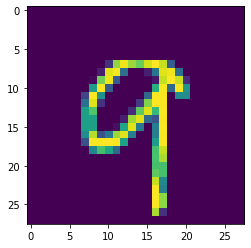

0
(1, 28, 28)


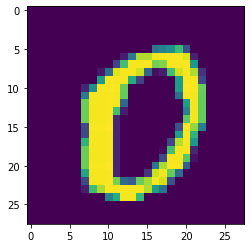

5
(1, 28, 28)


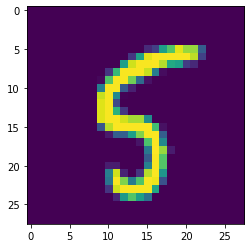

0
(1, 28, 28)


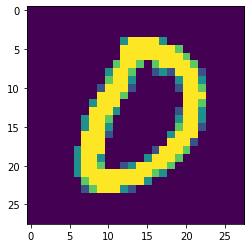

0
(1, 28, 28)


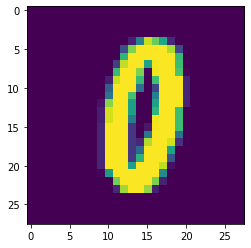

In [32]:
# Explore data
## YOUR CODE HERE ##

show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(28, 20)
        # self.fc2 = nn.Linear(20, 15)
        # self.fc3 = nn.Linear(15, 10)
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x = x.view(-1, 28)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [43]:
## YOUR CODE HERE ##

# Instantiate the model
net = Net()
net.to(device)

# Specify the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [46]:
## YOUR CODE HERE ##

train_loss_history = list()
val_loss_history = list()


# Train the neural network
for epoch in range(10):
    # Put the model into training mode
    net.train()
    
    # Set the epoch loss to zero
    train_loss = 0.0
    
    #Set the number of correct predictions to zero
    train_correct = 0
    
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
    # for i, (inputs, labels) in enumerate(train_loader, 0):
    
        # Pass input and labels to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
            
        # Zero out the gradient of the optimizer
        optimizer.zero_grad()
        
        # Get the output logits from the model
        outputs = net(inputs)
        
        # Computer the cross entropy loss between the outputs and the labels
        loss = criterion(outputs, labels)
        
        # Compute the gradient of the loss with respect to the parameters
        loss.backward()
        
        # Update the parameters by taking a step with the optimizer
        optimizer.step()

        # Get class predictions from the outputs
        _, preds = torch.max(outputs.data, 1)
        
        # Update the number of correct predictions from the epoch
        train_correct += (preds == labels).sum().item()
        
        # Update the running loss
        train_loss += loss.item()
        
    print(f'Epoch {epoch +1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))
    
    # Perform validation
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for input, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
        
    print(f'Epoch {epoch +1} validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(val_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))
    
        # running_loss += loss.item()
        # if i % 100 == 99:
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 100))
        #     running_loss = 0.0

Epoch 1 training accuracy: 15.18% training loss: 1.51171
Epoch 1 validation accuracy: 1.63% validation loss: 2.35932
Epoch 2 training accuracy: 15.22% training loss: 1.50992
Epoch 2 validation accuracy: 1.61% validation loss: 2.35981
Epoch 3 training accuracy: 15.22% training loss: 1.50974
Epoch 3 validation accuracy: 1.57% validation loss: 2.36290


KeyboardInterrupt: 

Plot the training loss (and validation loss/accuracy, if recorded).

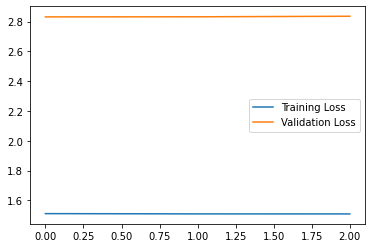

In [47]:
## YOUR CODE HERE ##

plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##